C:\Users\julie\AppData\Local\Temp\ipykernel_10968\2649264622.py:67: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(LSF,[0],colors='r',linewidth=2)


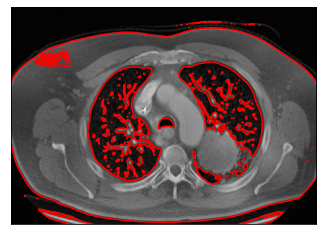

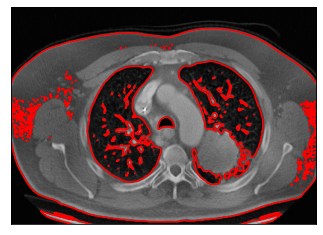

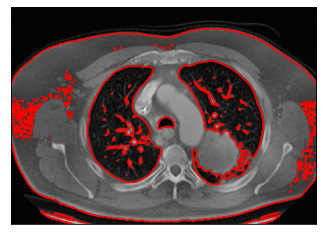

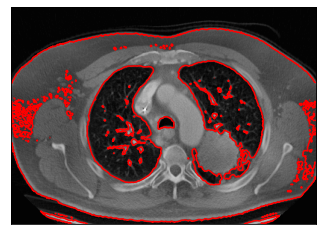

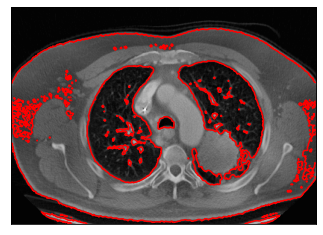

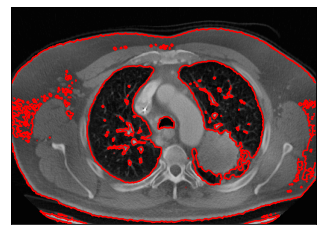

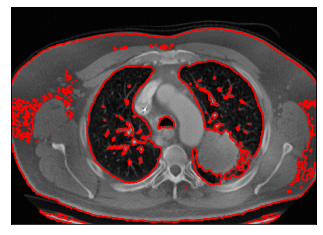

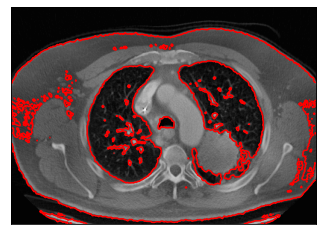

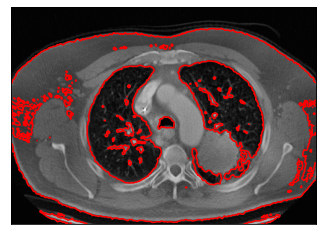

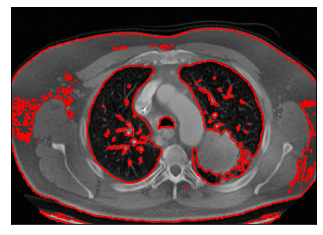

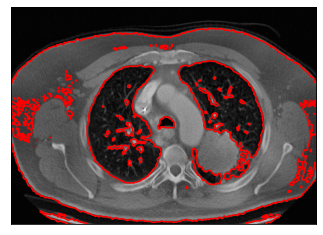

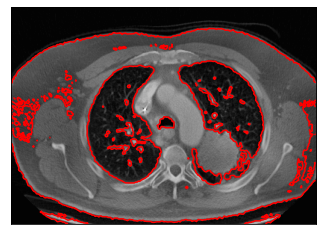

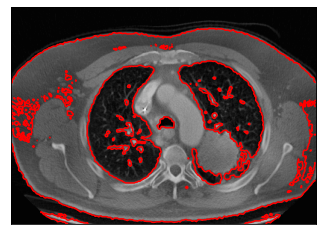

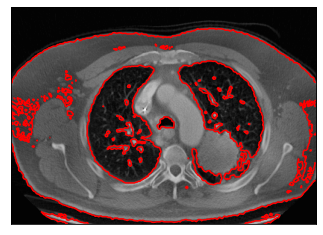

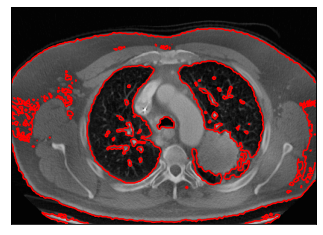

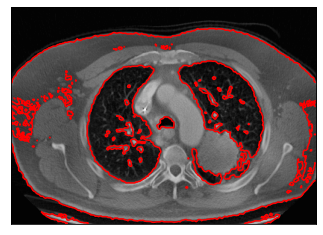

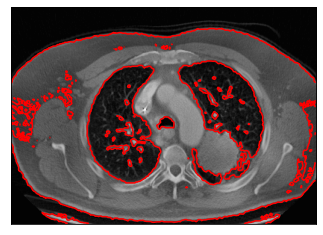

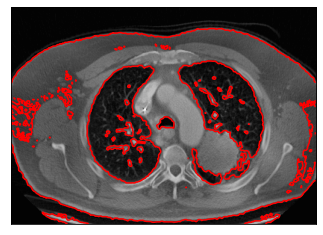

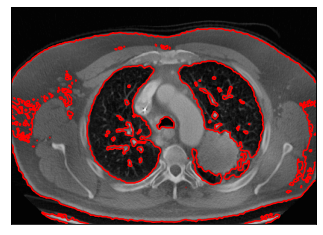

In [32]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from pylab import*

image = cv2.imread('Cancer.png',0)  
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
image = clahe.apply(image)
img=np.array(image,dtype=np.float64) 

IniLSF = np.ones((img.shape[0],img.shape[1]),img.dtype) 
IniLSF[30:80,30:80]= -1 
IniLSF=-IniLSF 


def mat_math (intput,str):
    output=intput 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if str=="atan":
                output[i,j] = math.atan(intput[i,j]) 
            if str=="sqrt":
                output[i,j] = math.sqrt(intput[i,j]) 
    return output 


def CV (LSF, img, mu, nu, epison,step):

    Drc = (epison / math.pi) / (epison*epison+ LSF*LSF)
    Hea = 0.5*(1 + (2 / math.pi)*mat_math(LSF/epison,"atan")) 
    Iy, Ix = np.gradient(LSF) 
    s = mat_math(Ix*Ix+Iy*Iy,"sqrt") 
    Nx = Ix / (s+0.000001) 
    Ny = Iy / (s+0.000001) 
    Mxx,Nxx =np.gradient(Nx) 
    Nyy,Myy =np.gradient(Ny) 
    cur = Nxx + Nyy 
    Length = nu*Drc*cur 

    Lap = cv2.Laplacian(LSF,-1) 
    Penalty = mu*(Lap - cur) 

    s1=Hea*img 
    s2=(1-Hea)*img 
    s3=1-Hea 
    C1 = s1.sum()/ Hea.sum() 
    C2 = s2.sum()/ s3.sum() 
    CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2)) 

    LSF = LSF + step*(Length + Penalty + CVterm) 
    #plt.imshow(s, cmap ='gray'),plt.show() 
    return LSF 


mu = 1
nu = 0.003 * 255 * 255 
num = 20
epison = 0.1
step = 0.1 
LSF=IniLSF 
for i in range(1,num):
    LSF = CV(LSF, img, mu, nu, epison,step) 
    if i % 1 == 0:   
        plt.imshow(image, cmap='gray'),plt.xticks([]), plt.yticks([])  
        plt.contour(LSF,[0],colors='r',linewidth=2) 
        plt.draw(),plt.show(block=False),plt.pause(0.01) 

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(filters=16,kernel_size=3,padding="same",activation="relu",input_shape=(50,50,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=3,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.summary()
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


#model.fit(X_train,y_train,batch_size=50,epochs=20,verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [58]:
import numpy as np
import cv2
import os

files = os.listdir("C:/Users/julie/OneDrive/Documents/Projet_IMIA/Medical_Imaging-1/Train")
X_train=[]
for img in files :
    test=cv2.imread("C:/Users/julie/OneDrive/Documents/Projet_IMIA/Medical_Imaging-1/Train/{}".format(img),0)
    X_train.append(test)

Watershed

71220.0


C:\Users\julie\AppData\Local\Temp\ipykernel_10968\2019883945.py:16: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)


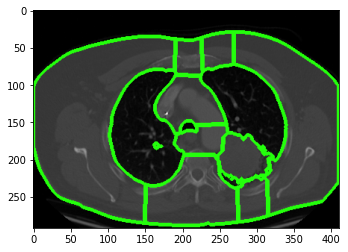

In [4]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import matplotlib.pyplot as plt

# Load in image, convert to gray scale, and Otsu's threshold
image = cv2.imread('Cancer.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Compute Euclidean distance from every binary pixel
# to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
total_area = 0
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    total_area += area
    cv2.drawContours(image, [c], -1, (36,255,12), 4)

print(total_area)
plt.imshow(image)
plt.show()